# EMOTION CLASSIFICATION AND SENTIMENT ANALYSIS.
### Using Python 3.7.5.
### Convolutional Neural Network.
###### __author__ = "Shakir Sadiq"

**Import all the required modules and packages.**

In [1]:
import pandas
import numpy
import re
import nltk
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

Using TensorFlow backend.


**Import dataset and create dataframes.**
*  Using pandas

In [2]:
dataframe_test = pandas.read_csv(r"C:\Users\shaki\Desktop\ecsa\datasets\data_test.csv")
dataframe_train = pandas.read_csv(r"C:\Users\shaki\Desktop\ecsa\datasets\data_train.csv")

**Split dataframes into training and testing.**
*  Using Pandas

In [3]:
#Text column from csv file
text_test = dataframe_test.Text
text_train = dataframe_train.Text

#emotion column from csv file
emotion_test = dataframe_test.Emotion
emotion_train = dataframe_train.Emotion

#concatenate dataframes of both the datasets
data = pandas.concat([dataframe_train, dataframe_test])
print("size of training set:",(len(dataframe_train['Text'])))
print("size of testing set:",(len(dataframe_test['Text'])))
print(data.Emotion.value_counts()) #size of each individual emotion

size of training set: 7934
size of testing set: 3393
joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: Emotion, dtype: int64


**Data cleaning:**
*  Cleaning datasets and getting them down to a form with which we can work.
*  Using regex.
*  nltk for tokenization.

In [4]:
htmltags = r"(<.*?>)"
urls = r"^https?:\/\/.*[\r\n]*"
punctuation = r"(\\W|\\d)"
hashtags = r"(#[\d\w\.]+)"

def cleaning_tokenization(data):
    '''function for data cleaning and tokenization'''
    data = re.sub(htmltags, " ", str(data)) #remove html tags
    data = re.sub(urls, " ", str(data)) #remove urls
    data = re.sub(punctuation, " ", str(data)) #remove punctuation
    data = re.sub(hashtags, " ", str(data)) #remove hashtags
    data = data.strip() #remove whitespaces

    data = nltk.word_tokenize(str(data)) #tokenization using nltk
    
    return data

**Tokenization:**
*  Tokenization basically refers to splitting up a larger body of text into smaller lines.
*  Using Keras

In [5]:
texts = [' '.join(cleaning_tokenization(text)) for text in data.Text]
texts_test = [' '.join(cleaning_tokenization(text)) for text in text_test]
texts_train = [' '.join(cleaning_tokenization(text)) for text in text_train]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_test = tokenizer.texts_to_sequences(texts_test)
sequence_train = tokenizer.texts_to_sequences(texts_train)

index_of_words = tokenizer.word_index

#Number of unique words + reserved 0 index for padding
vocabulary_size = len(index_of_words) + 1

print("Number of unique words:",len(index_of_words))

Number of unique words: 12237


**Padding:**
*  Each input has to be of the same length.
*  Using Keras.

In [6]:
maximum_sequence_length = 500 #Maximum input length
text_test_pad = pad_sequences(sequence_test, maxlen = maximum_sequence_length)
text_train_pad = pad_sequences(sequence_train, maxlen = maximum_sequence_length)

text_train_pad

array([[    0,     0,     0, ...,   119,    51,   345],
       [    0,     0,     0, ...,    37,   277,   154],
       [    0,     0,     0, ...,    16,     2,  1210],
       ...,
       [    0,     0,     0, ...,   876,     4,   909],
       [    0,     0,     0, ...,     1,     6,   117],
       [    0,     0,     0, ..., 10364,   173,    13]])

**Encoding of emotion categories:**
*  Labels have to be converted to integeres and categorized.
*  Using Keras.

In [7]:
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

#Integer labels
emotion_test = [encoding[i] for i in dataframe_test.Emotion]
emotion_train = [encoding[i] for i in dataframe_train.Emotion]

#to_categorical function --- Converts a class vector (integers) to binary class matrix.
emotion_test = to_categorical(emotion_test)
emotion_train = to_categorical(emotion_train)

emotion_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

**Importing pretrained word2vec:**
* Importing pretrained word2vec from file and creating embedding matrix and we will later map each word in our corpus to existing word vector.
* Word Embedding is a representation of text where words that have the similar meaning have a similar representation.
* We will use 300 dimentional word vectors pre-trained on wikipedia articles.

In [8]:
embedding_number_dimensions = 300 #number of dimensions for word embedding

def create_embedding_matrix(filepath, word_index, embedding_dimensions):
    '''function for importing pretrained word vectors'''
    print("Please wait...! Embedding in Process...!")
    vocabulary_size = len(word_index) + 1  #Adding again 1 because of reserved 0 index
    embedding_matrix = numpy.zeros((vocabulary_size, embedding_dimensions))
    
    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = numpy.array(vector, dtype=numpy.float32)[:embedding_dimensions]
    return embedding_matrix

filename = r"C:\Users\shaki\Desktop\ecsa\word2vector\wiki-news-300d-1M.vec"
embedd_matrix = create_embedding_matrix(filename, index_of_words, embedding_number_dimensions)
embedd_matrix.shape

Please wait...! Embedding in Process...!


(12238, 300)

**Inspecting new words after embedding:**
*  Using pretrained word vectors.

In [9]:
new_words = 0
for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print("Words found in pretrained wiki word vector: ", str(len(index_of_words) - new_words))
print("New words found: ", str(new_words))

Words found in pretrained wiki word vector:  11449
New words found:  788


**Embedding Layer:**
*  vocabulary size: the maximum number of terms that are used to represent a text.
*  size of embeddings: The more dimensions we have the more precise the semantics will be.
*  trainable: True if you want to fine-tune them while training.

In [10]:
#It maps the integer inputs to the vectors found at the corresponding index in the embedding matrix
embedding_layer = Embedding(vocabulary_size,
                         embedding_number_dimensions,
                         input_length = maximum_sequence_length,
                         weights = [embedd_matrix],
                         trainable=False)

**Convolutional neural network:**
*  Though text data is one-dimensional, we can use 1D convolutional neural networks to extract features from our data.
*  The result of each convolution will fire when a special pattern is detected.
*  Using Keras.layers.

In [11]:
number_of_categories = 5 #Total number of emotions.
kernel_size = 3 #Specifying the length of the convolution window.
filters = 256 #Total number of windows you will have.

model = Sequential()  #Initializing the neural network
model.add(embedding_layer)
#Used relu function to ensure that we don't have negative pixel values during computation.
model.add(Conv1D(filters, kernel_size, activation='relu')) #Convulation layer
model.add(GlobalMaxPooling1D()) #reduce the size of the feature map without losing important image information.
model.add(Dense(256, activation='relu')) #dense is a fully connected layer (receives input from all neurons).
#activation function(softmax) used in the output layer that predict a multinomial probability distribution.
model.add(Dense(number_of_categories, activation='softmax'))

#loss = 'categorical_crossentropy' --- loss function (measure of how good your prediction model does).
#optimizer = 'adam' --- optimization algorithm.
#metrics = ['accuracy'] --- specifies the evaluation criteria for the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          3671400   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 498, 256)          230656    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 3,969,133
Trainable params: 297,733
Non-trainable params: 3,671,400
_________________________________________________________________


## Train the model.

In [12]:
batch_size = 256 #The number of samples that are passed to the network at once.
epochs = 6 #The number of times a learning algorithm sees the complete dataset.

hist = model.fit(text_train_pad, emotion_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(text_test_pad,emotion_test))

Train on 7934 samples, validate on 3393 samples
Epoch 1/6
7934/7934 [==============================] - 2173s 274ms/step - loss: 1.3656 - accuracy: 0.4613 - val_loss: 1.1170 - val_accuracy: 0.6113
Epoch 2/6
7934/7934 [==============================] - 2157s 272ms/step - loss: 0.8351 - accuracy: 0.7162 - val_loss: 0.7827 - val_accuracy: 0.7147
Epoch 3/6
7934/7934 [==============================] - 2132s 269ms/step - loss: 0.6038 - accuracy: 0.7962 - val_loss: 0.7280 - val_accuracy: 0.7401
Epoch 4/6
7934/7934 [==============================] - 2174s 274ms/step - loss: 0.4887 - accuracy: 0.8426 - val_loss: 0.7118 - val_accuracy: 0.7498
Epoch 5/6
7934/7934 [==============================] - 2179s 275ms/step - loss: 0.3871 - accuracy: 0.8864 - val_loss: 0.6915 - val_accuracy: 0.7583
Epoch 6/6
7934/7934 [==============================] - 2186s 276ms/step - loss: 0.2964 - accuracy: 0.9227 - val_loss: 0.7054 - val_accuracy: 0.7521


**Graph Plotting:**
*  Accuracy Plot.
*  Loss Plot.
*  Using matplotlib.pyplot

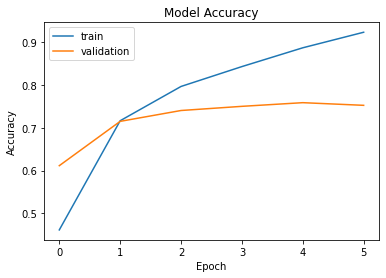

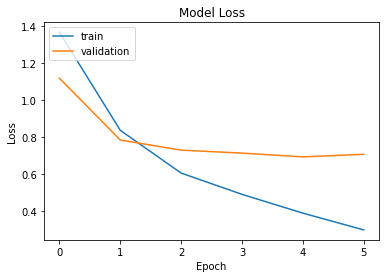

In [13]:
#Accuracy plot
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "validation"], loc = "upper left") #This function will provide the name of different lines in the graph.
plt.show()

#Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "validation"], loc = "upper left")
plt.show()

## Evaluation Of the Trained model.
**F1-Score & Accuracy Percentage.**
*  Using Scikit_learn.

In [14]:
emotion_categories = ['joy', 'fear', 'anger', 'sadness', 'neutral']

predictions = model.predict(text_test_pad)
predictions = numpy.argmax(predictions, axis=1)
predictions = [emotion_categories[pred] for pred in predictions]

#Accuracy is used when the True Positives and True negatives are more important.
print("Accuracy: ", (accuracy_score(dataframe_test.Emotion, predictions) * 100),"%")
#F1-score is used when the False Negatives and False Positives are crucial.
print("\nF1 Score: ", (f1_score(dataframe_test.Emotion, predictions, average='micro') * 100))

Accuracy:  75.21367521367522 %

F1 Score:  75.2136752136752


**Confusion Matrix**
*  Visualization of the data.
*  Using Scikit-learn.

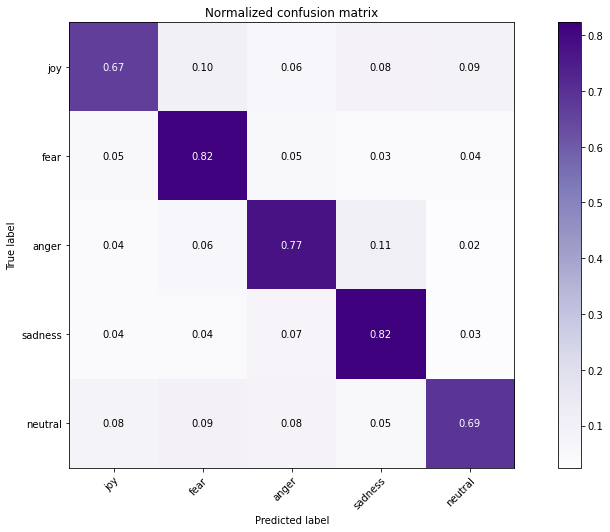

In [15]:
def plot_confusion_matrix(true_values, predicted_values, classes, normalize=False, title=None, cmap=plt.cm.Purples):
    '''This function prints and plots the confusion matrix'''
    if not title:
        if normalize:
            title = "Normalized confusion matrix"
        else:
            title = "Confusion matrix without normalization"
    
    #Compute confusion matrix
    cm = confusion_matrix(true_values, predicted_values)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, numpy.newaxis]
    fig, ax = plt.subplots()
    
    #size of the confusion matrix
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)

    #labels around the matrix
    ax.set(xticks=numpy.arange(cm.shape[1]),
           yticks=numpy.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel="True label",
           xlabel="Predicted label")
    
    #alignment of labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    #create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

#Plot normalized confusion matrix
plot_confusion_matrix(dataframe_test.Emotion, predictions, classes=emotion_categories, normalize=True)
plt.show()

## Results.
**Predictions by our model**

In [16]:
message = ["that movie was really scary"]

sequence = tokenizer.texts_to_sequences(message)
padded = pad_sequences(sequence, maxlen=maximum_sequence_length)

predict = model.predict(padded)

print("Message:", message)
print("Predicted:", emotion_categories[numpy.argmax(predict)])

Message: ['that movie was really scary']
Predicted: fear


**Saving the model for later use.**

In [17]:
model.save("C:/Users/shaki/Desktop/ecsa/models/cnn.h5")

**Saving the tokenizer for later use.**

In [18]:
with open("C:/Users/shaki/Desktop/ecsa/tokenizer/tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)